In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
df1516 = pd.read_csv('../../data/FINAL2016.csv')
df1920 = pd.read_csv('../../data/FINAL2020.csv')

targets = pd.read_csv('../../data/flipped.csv')


ca2015 = pd.read_csv('../../data/vax_df/ca_vax_df_2015.csv')
fl2015 = pd.read_csv('../../data/vax_df/fl_vax_df_2015.csv')
il2015 = pd.read_csv('../../data/vax_df/il_vax_df_2015.csv')
tx2015 = pd.read_csv('../../data/vax_df/tx_vax_df_2015.csv')
ca2018 = pd.read_csv('../../data/vax_df/ca_vax_df_2018.csv')
fl2019 = pd.read_csv('../../data/vax_df/fl_vax_df_2019.csv')
il2018 = pd.read_csv('../../data/vax_df/il_vax_df_2018.csv')
tx2018 = pd.read_csv('../../data/vax_df/tx_vax_df_2018.csv')
mi2018 = pd.read_csv('../../data/vax_df/mi_vax_df_2019.csv')

vax2015 = pd.concat([ca2015, fl2015, il2015, tx2015])
vax2015['fip'] = vax2015['fips']
vax2019 = pd.concat([ca2018, fl2019, il2018, tx2018, mi2018])
vax2019['fip'] = vax2019['fips']
df1516 = pd.merge(vax2015, df1516, on = 'fip')
df1920 = pd.merge(vax2019, df1920, on = 'fip')


In [2]:
flipped = pd.read_csv('../../data/flipped.csv')

In [3]:
flipped.shape

(21, 6)

In [4]:
df1516 = df1516.set_index('FIPS')
y_train = df1516['target_2016']
X_train = df1516.drop(['Unnamed: 0', 'unnamed:_0', 'target_2016', 'fip', 'in_civilian_labor_force',
       'under_19_no_health_insurance_coverage',
       '19_to_34_years_no_health_insurance_coverage',
       '35_to_64_years_no_health_insurance_coverage', 'health_insurance_total',
       '65_years_and_over_no_health_insurance_coverage',
       'total_population_estimate', 'state_fip', 'county_fip',
       'Total Areami²', 'fips', 'total_production,_transportation,_and_material_moving_occupations',], axis=1)

df1920 = df1920.set_index('FIPS')
y_val = df1920['target_2020']
X_val = df1920.drop(['Unnamed: 0','unnamed:_0',  'target_2020', 'fip','in_civilian_labor_force',
       'under_19_no_health_insurance_coverage',
       '19_to_34_years_no_health_insurance_coverage',
       '35_to_64_years_no_health_insurance_coverage', 'health_insurance_total',
       '65_years_and_over_no_health_insurance_coverage',
       'total_population_estimate', 'state_fip', 'county_fip',
       'Total Areami²', 'total_production,_transportation,_and_material_moving_occupations', 'fips'], axis=1)


In [6]:
X_flipped = X_tests[X_tests.index.isin(flipped.FIPS_x)]
y_flipped = y_tests.loc[X_flipped.index]
#fips = X_val.FIPS

NameError: name 'X_tests' is not defined

In [7]:
#X_val, X_test, y_val, y_test = train_test_split(X_tests, y_tests, test_size=0.5, random_state=2021)

In [8]:
scaler = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=X_val.columns, index=X_val.index)

In [9]:
# Previous original class distribution
print('Original class distribution: \n')
print(y_train.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_scaled, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    373
0     49
Name: target_2016, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    373
0    373
Name: target_2016, dtype: int64


In [10]:
#results.error.sum()

In [11]:
logreg = LogisticRegression(random_state=2021, solver='liblinear', penalty='l2')
dt = DecisionTreeClassifier(random_state=2021, max_depth=3)
rfc= RandomForestClassifier(random_state=2021, max_features = 'auto', n_estimators = 700)

#XGboost 
def modeling_function(model, X_train, y_train, X_val, y_val):
    #fit model to training data
    model.fit(X_train, y_train)    #make predictions on train and validation
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)    #output metrics
    print(model, ': Training Recall', recall_score(y_train, train_preds))
    print('Validation Recall', recall_score(y_val, val_preds))
    print('Training Accuracy', accuracy_score(y_train, train_preds))
    print('Validation Accuracy', accuracy_score(y_val, val_preds))
    print('Training Precicion', precision_score(y_train, train_preds))
    print('Validation Precision', precision_score(y_val, val_preds))
    print('Training F1', f1_score(y_train, train_preds))
    print('Validation F1', f1_score(y_val, val_preds))
    val_preds = pd.Series(model.predict(X_val))
    val_preds.index = y_val.index

    logreg_val_results = pd.DataFrame(y_val.values, columns=['true'], index=y_val.index)
    logreg_val_results['pred'] = val_preds
    logreg_val_results = logreg_val_results.join(df1516[['target_2016']]).dropna()
    logreg_no_flip = logreg_val_results[~logreg_val_results.index.isin(flipped.FIPS_x)]
    logreg_flip = logreg_val_results[logreg_val_results.index.isin(flipped.FIPS_x)]
    flip_prediction_rate = len(logreg_flip[logreg_flip.pred != logreg_flip.target_2016])/(len(logreg_flip[logreg_flip.pred != logreg_flip.target_2016]) +len(logreg_no_flip[logreg_no_flip.pred != logreg_no_flip.target_2016]))
    print('flip prediction rate', flip_prediction_rate)
    return model, logreg_flip


In [12]:
model1 = modeling_function(logreg, X_train_resampled, y_train_resampled, X_val_scaled, y_val)

LogisticRegression(random_state=2021, solver='liblinear') : Training Recall 0.9544235924932976
Validation Recall 0.8108108108108109
Training Accuracy 0.9705093833780161
Validation Accuracy 0.8075396825396826
Training Precicion 0.9861495844875346
Validation Precision 0.9651474530831099
Training F1 0.9700272479564032
Validation F1 0.8812729498164016
flip prediction rate 0.1875


In [13]:
# val_preds = pd.Series(logreg.predict(X_val_scaled))
# val_preds.index = y_val.index

# logreg_val_results = pd.DataFrame(y_val.values, columns=['true'], index=y_val.index)
# logreg_val_results['pred'] = val_preds
# logreg_val_results = logreg_val_results.join(df1516[['target_2016']]).dropna()

In [14]:
# logreg_no_flip = logreg_val_results[~logreg_val_results.index.isin(flipped.FIPS_x)]
# logreg_flip = logreg_val_results[logreg_val_results.index.isin(flipped.FIPS_x)]

In [15]:
# len(logreg_flip[logreg_flip.pred != logreg_flip.target_2016])/(len(logreg_flip[logreg_flip.pred != logreg_flip.target_2016]) +len(logreg_no_flip[logreg_no_flip.pred != logreg_no_flip.target_2016]))




In [16]:
#logreg_flip[logreg_flip.pred != logreg_flip.target_2016]

In [17]:
model3 = modeling_function(rfc, X_train_resampled, y_train_resampled, X_val_scaled, y_val)

RandomForestClassifier(n_estimators=700, random_state=2021) : Training Recall 1.0
Validation Recall 0.9932432432432432
Training Accuracy 1.0
Validation Accuracy 0.9484126984126984
Training Precicion 1.0
Validation Precision 0.9504310344827587
Training F1 1.0
Validation F1 0.9713656387665198
flip prediction rate 0.42857142857142855


In [18]:
# model_2020_preds = pd.DataFrame()
# model_2020_preds['preds'] = rfc.predict(X_val_scaled)
# model_2020_preds.index = X_val_scaled.index
# model_2020_preds['true_2020'] = y_val
# model_2020_preds = model_2020_preds.join(df1516[['target_2016']]).dropna()


In [19]:
#flip_preds = model_2020_preds[model_2020_preds.preds != model_2020_preds.target_2016]

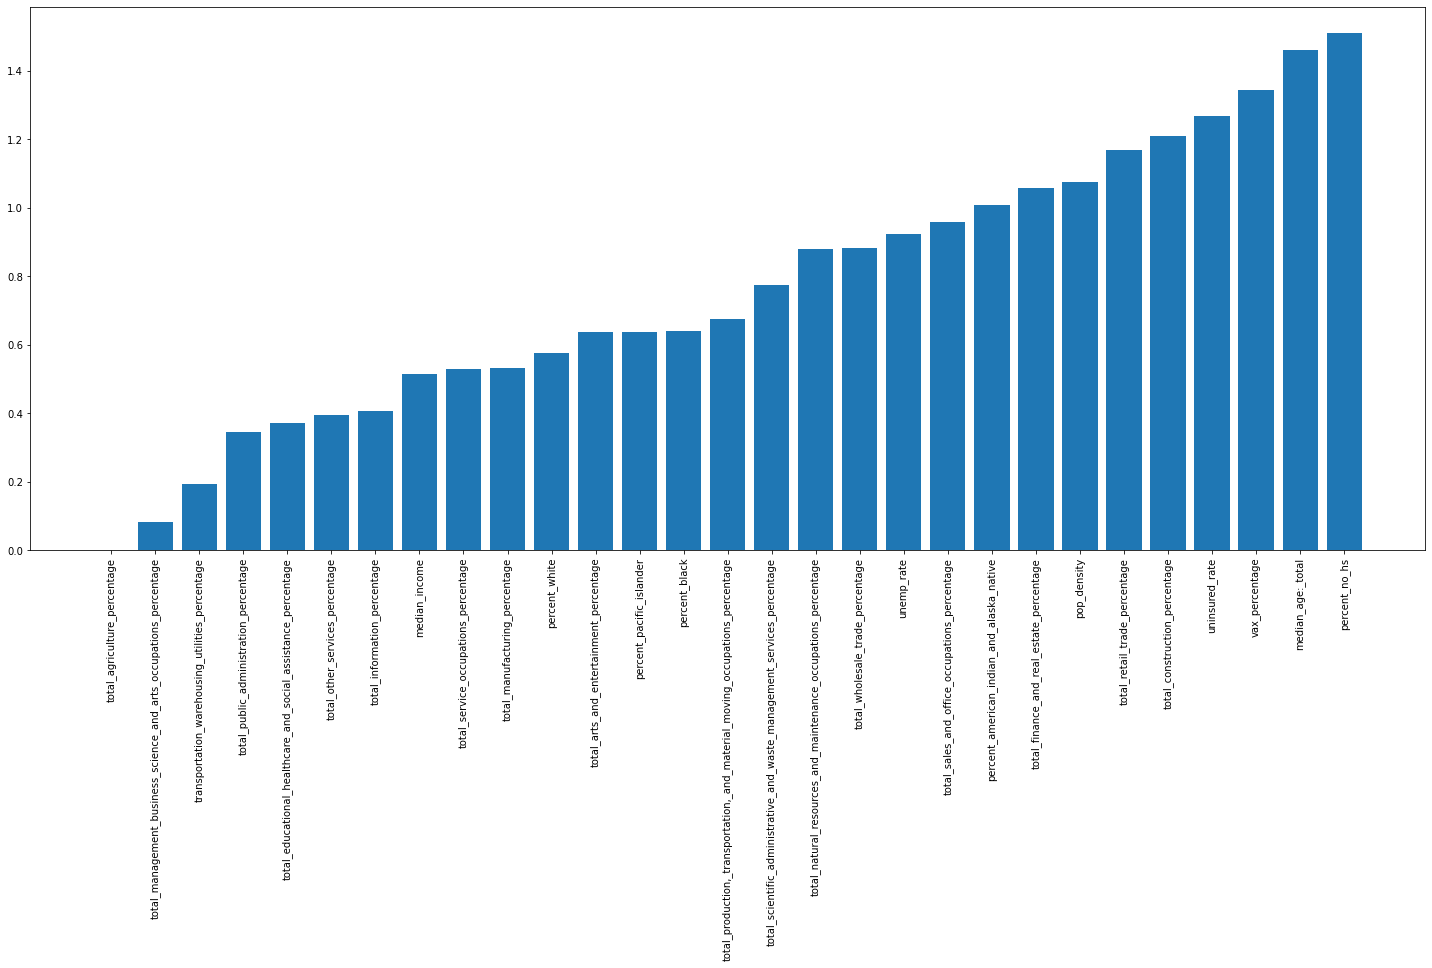

In [20]:
zipped = sorted(list(zip(np.abs(model1[0].coef_[0]), X_train_resampled.columns)))
x = [_[1] for _ in zipped]
y = [_[0] for _ in zipped]
plt.figure(figsize=(25,10))
plt.bar(x, y)
plt.xticks(rotation=90);

In [21]:
model2 = modeling_function(dt, X_train_resampled, y_train_resampled, X_val_scaled, y_val)

DecisionTreeClassifier(max_depth=3, random_state=2021) : Training Recall 0.900804289544236
Validation Recall 0.9436936936936937
Training Accuracy 0.900804289544236
Validation Accuracy 0.8670634920634921
Training Precicion 0.900804289544236
Validation Precision 0.9088937093275488
Training F1 0.900804289544236
Validation F1 0.9259668508287293
flip prediction rate 0.08333333333333333


In [22]:
from sklearn.inspection import permutation_importance

In [23]:
results = permutation_importance(rfc, X_train_resampled, y_train_resampled, scoring='f1', random_state=2021)

<ipython-input-101-b564405c90f9>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, ['wholesale trade %', 'information %', 'education', 'healthcare & social assistance %', 'arts & entertainment %', 'transportation & warehousing utilities %', 'finance & real estate %', '% indigenous/first nations', '% uninsured', 'manufacturing %', '% unemployed', 'agriculture %', 'construction %'])


TypeError: 'int' object is not callable

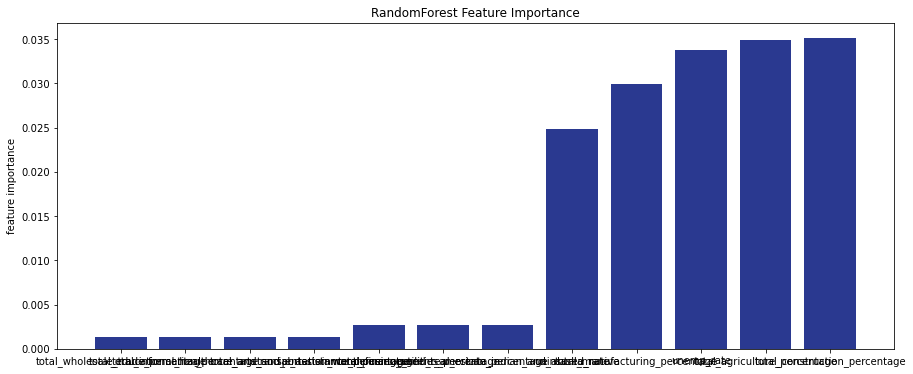

In [101]:
rfc_importance = sorted(list(zip(X_train_resampled.columns, results.importances.ravel())), key=lambda x: x[1])
fig, ax = plt.subplots(figsize=(15,6))
x = [_[0] for _ in rfc_importance]
y = [_[1] for _ in rfc_importance]
x = x[17:]
y = y[17:]
#plt.figure(figsize=(15,6))
plt.bar(x, y, color='#2A3990')
plt.title('RandomForest Feature Importance')
plt.ylabel('feature importance')
#plt.tick_params(axis=x,)
ax.set_xticks(x, ['wholesale trade %', 'information %', 'education', 'healthcare & social assistance %', 'arts & entertainment %', 'transportation & warehousing utilities %', 'finance & real estate %', '% indigenous/first nations', '% uninsured', 'manufacturing %', '% unemployed', 'agriculture %', 'construction %'])
plt.xticks(rotation=45);

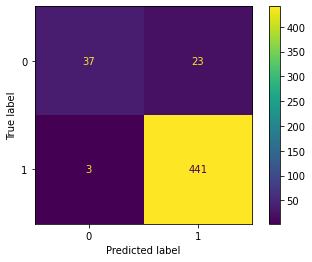

In [25]:
# from sklearn.feature_selection import RFE
# scores = []
# feature_list = list(X_train_scaled.columns)
# for num in range(1, X_train_scaled.shape[1]):
    
#     selector = RFE(logreg, n_features_to_select=num, step=1)
#     selector = selector.fit(X_train_scaled, y_train)
#     score = selector.score(X_val_scaled, y_val)
#     scores.append(score)
# selector = RFE(logreg, n_features_to_select=1, step=1)
# selector = selector.fit(X_train_scaled, y_train)
# score = selector.score(X_val_scaled, y_val)
# feature_importance = ca_list_dict = dict(zip(feature_list,selector.ranking_))

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model3[0], X_val_scaled, y_val)

In [26]:
val_preds = logreg.predict(X_val_scaled)
preds = pd.DataFrame()
preds['preds'] = val_preds
preds['FIPS_x'] = X_tests[X_tests.FIPS.isin(flipped.FIPS_x)].reset_index().FIPS
results = flipped.merge(preds, on='FIPS_x')
results['error'] = np.abs(results['target_2020'] - results['preds'])

results.groupby('state').sum()

NameError: name 'X_tests' is not defined

In [ ]:

flip_preds.to_csv('../../data/flip_preds.csv', index=True)
